In [1]:
import numpy as np
import pyGM as gm
import networkx as nx
import matplotlib.pyplot as plt

# Maximum Likelihood

Load the data into python corresponding to the following Bayesian network:
![](bg.png)

In [2]:
d = np.genfromtxt('RiskFactorData.csv', delimiter=',', names=True)
data_int = np.array([list(xj) for xj in d], dtype=int)-1
nTrain = int(0.75*len(data_int))
training = data_int[:nTrain]
validation = data_int[nTrain:]

Now we want to estimate the probabilities required for the following Bayesian network, using maximumlikelihood on the training data.

In [3]:
var_name = {0: 'Income', 1: 'Smoke', 2: 'Cholesterol', 3: 'BMI',
            4: 'Exercise', 5: 'Attack', 6: 'BP', 7: 'Angina',
            8: 'Stroke', 9: 'Diabetes'}

Income, Smoke, Cholesterol, BMI, Exercise, Attack, BP, Angina, Stroke, Diabetes = tuple(gm.Var(i, v) for i, v in enumerate([8, 2, 2, 4, 2, 2, 4, 2, 2, 4]))
X = [Income, Smoke, Cholesterol, BMI, Exercise, Attack, BP, Angina, Stroke, Diabetes]

factor_map = {0: [0], 1: [0, 1], 2: [0, 1, 2, 4], 3: [0, 3, 4],
              4: [0, 4], 5: [2, 3, 5, 6], 6: [0, 1, 4, 6],
              7: [2, 3, 6, 7], 8: [2, 3, 6, 8], 9: [3, 9]}


def get_column(d, idx):
    result = []
    for row in d:
        result.append(row[idx])
    return result 


def print_tables(pml):
      # p(Income) Table
    tableLine = '-----------------'
    print('{0}\n| I | p(Income) |\n{0}'.format(tableLine))
    for i, v in enumerate(pml[0].table):
        print('| {} |    {:<4}   |'.format(i, round(v, 2)))
    print(tableLine, '\n')

    # p(Exercise|Income) Table
    tableLine = '-----------------------------'
    print('      -----------------------\n      | p(Exercise|Income)  |')
    print(tableLine + '\n| I/E |     0    |     1    |\n' + tableLine)
    for i, v in enumerate(pml[1].table):
        print('|  {}  |   {:<4}   |   {:<4}   |'.format(i, round(v[0], 2), round(v[1], 2)))
    print(tableLine, '\n')  
    
    
def populate(data, p, i):
    for d in data:
        if i == 0:
            p.t[int(d[0])]+=1
        elif i == 1:
            p.t[d[Income]][d[Smoke]]+=1
        elif i == 2:
            p.t[d[Income]][d[Smoke]][d[Cholesterol]][d[Exercise]]+=1
        elif i == 3:
            p.t[d[Income]][d[BMI]][d[Exercise]]+=1
        elif i == 4:
            p.t[d[Income]][d[Exercise]]+=1
        elif i == 5:
            p.t[d[Cholesterol]][d[BMI]][d[Attack]][d[BP]]+=1
        elif i == 6:
            p.t[d[Income]][d[Smoke]][d[Exercise]][d[BP]]+=1
        elif i == 7:
            p.t[d[Cholesterol]][d[BMI]][d[BP]][d[Angina]]+=1
        elif i == 8:
            p.t[d[Cholesterol]][d[BMI]][d[BP]][d[Stroke]]+=1
        elif i == 9:
            p.t[d[BMI]][d[Diabetes]]+=1
    if i == 0:
        p/=p.sum()
    else:
        p/=p.sum([X[i]])
    return p 

In [4]:
def maxLikelihoodModel(data, display_data = False, prior = False):        
    factors = []
    tables = []
    for i in range(10):
        if prior:
            Pml = gm.Factor([X[f] for f in factor_map[i]], 1.0)
        else:
            Pml = gm.Factor([X[f] for f in factor_map[i]], 0.0)
        Pml = populate(data, Pml, i)
        factors.append(Pml)
        if i in [0, 4]:
            tables.append(Pml)
    return (gm.GraphModel(factors), tables)
    
    
model, tables = maxLikelihoodModel(training, True)
print_tables(tables)

-----------------
| I | p(Income) |
-----------------
| 0 |    0.05   |
| 1 |    0.06   |
| 2 |    0.07   |
| 3 |    0.09   |
| 4 |    0.12   |
| 5 |    0.15   |
| 6 |    0.16   |
| 7 |    0.3    |
----------------- 

      -----------------------
      | p(Exercise|Income)  |
-----------------------------
| I/E |     0    |     1    |
-----------------------------
|  0  |   0.62   |   0.38   |
|  1  |   0.61   |   0.39   |
|  2  |   0.63   |   0.37   |
|  3  |   0.66   |   0.34   |
|  4  |   0.7    |   0.3    |
|  5  |   0.75   |   0.25   |
|  6  |   0.79   |   0.21   |
|  7  |   0.85   |   0.15   |
----------------------------- 



Now we want to find the average log-likelihood on the training data using the model we have created.

In [5]:
def calc_log_likelihood(m, data):
    LL_Dependent = np.mean([m.logValue(xj) for xj in data])
    return LL_Dependent

print('LL_Training:', calc_log_likelihood(model, training))

LL_Training: -6.806920101456448


Now lets do the same for the validation data!

In [6]:
print('LL_Validation:', calc_log_likelihood(model, validation))

/Users/Eisah/Desktop/Notebooking/pyGM/graphmodel.py:178: RuntimeWarning: divide by zero encountered in log
  else:          return sum( [ np.log(f.valueMap(x)) for f in factors ] )


LL_Validation: -inf


You can see that we get a value of -inf. This is because there may be some examples in the validation data that were not observed in the training data. To handle this situation, we can include a Dirchlet prior using a value of 1.

In [7]:
model_ = maxLikelihoodModel(training, False, prior = True)[0]
print('LL_Training  :', calc_log_likelihood(model_, training))
print('LL_Validation:', calc_log_likelihood(model_, validation))

LL_Training  : -6.806954057154673
LL_Validation: -6.852285489262171


Now we can see that we are recieving roughly the same value on both the training and validation data.

# Learning Graph Structure

Let's wstimate the single-variable and pairwise marginal probability distributions p(Xi), p(Xi, Xj) for each pair of variables in the model.

In [8]:
def chowLiuModel(data, prior = False):
    factors = []
    for var in X:
        col_values = get_column(data, var.label)
        occurences = [0]*var.states
        for i in range(var.states):
            occurences[i] = col_values.count(i)
        probs = [ float(v)/sum(occurences) for v in occurences]
        factors.append( gm.Factor([var], probs) )
    
    m = gm.GraphModel(factors)
    
    phat = {}
    for v in m.X:
        phat[v] = gm.Factor([v], 1e-15)
        for d in data: 
            phat[v][d[v]] += 1.0
        phat[v] /= len(data)
        
    for v in m.X:
        for w in m.X:
            if w<=v: continue
            phat[v, w] = gm.Factor([v, w], 1e-15)
            for d in data: 
                phat[v, w][d[v],d[w]] += 1.0
            phat[v, w] /= len(data)
            
    weights = np.zeros((10, 10))
    for v in X:
        for w in X:
            if w<=v: continue
            weights[v, w] = ( phat[v, w] * (phat[v,w]/phat[v]/phat[w]).log()).sum()
            
    return (m, weights, phat)


model2, treeWeights, phat = chowLiuModel(training)
print(np.round(treeWeights, 4))

[[0.     0.0084 0.0052 0.0067 0.0194 0.0098 0.0198 0.0071 0.0095 0.0154]
 [0.     0.     0.004  0.0004 0.0031 0.0055 0.0035 0.0042 0.0016 0.0013]
 [0.     0.     0.     0.0097 0.003  0.0101 0.0428 0.0145 0.004  0.0196]
 [0.     0.     0.     0.     0.0091 0.0011 0.0281 0.0016 0.0004 0.0258]
 [0.     0.     0.     0.     0.     0.0029 0.0074 0.0024 0.0025 0.006 ]
 [0.     0.     0.     0.     0.     0.     0.0137 0.0569 0.0115 0.0096]
 [0.     0.     0.     0.     0.     0.     0.     0.0177 0.0091 0.0386]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.0087 0.01  ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0046]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


The table above displays the empirical mutual information between each pair of variables in the network.

Now we want to estimate the maximum likelihood tree model structure.

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


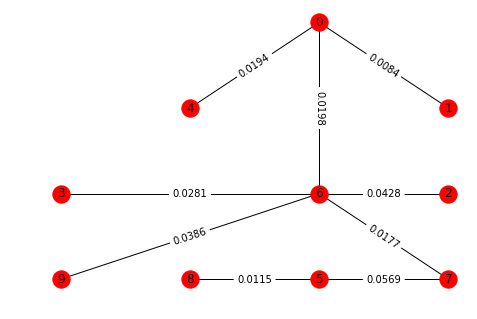

In [9]:
G = nx.Graph()
pos = {0: (1, 1), 1: (2, 0), 2: (2, -1), 3: (-1, -1),
       4: (0, 0), 5: (1, -2), 6: (1, -1),
       7: (2, -2), 8: (0, -2), 9: (-1, -2)}
for v in X: G.add_node(int(v))
for i in range(10):
    for j in range(i+1, 10):
        G.add_edge(i, j, weight = treeWeights[i, j])
        
T = nx.maximum_spanning_tree(G)
labels = {}
p = []
for x in sorted(T.edges(data=True)):
    labels[(x[0], x[1])] = np.round(x[2]['weight'], 4)
    p.append((x[0], x[1]))
nx.draw(T, pos, with_labels = True)
nx.draw_networkx_edge_labels(T, pos, edge_labels=labels)
print()

Now that we have generated a graph representing the relationship between variables in the dataset, we can compute the average log-likelihood on the training and validation data.

In [10]:
estimates = [phat[i] for i in range(10)] + \
            [phat[i, j]/phat[i]/phat[j] for i, j in p]
est_model = gm.GraphModel(estimates)
print('LL_Training:', np.mean( [ est_model.logValue(x) for x in training ] ))
print('LL_Valiidation:', np.mean( [ est_model.logValue(x) for x in validation ] ))

LL_Training: -6.722457217345808
LL_Valiidation: -6.765482079662603


We can see that both of these values are slightly lower than the values calculated in the first section.

However, our model from the first part and our new tree-structured model have very different complexities. We want to penalize the model for it's complexity. To do this we change the training likelihoods by including a BIC penalty.

In [11]:
def calc_BIC(m, data):
    BIC = np.mean([m.logValue(xj) for xj in data])
    BIC -= (len(X)/2.0)*np.log(len(data))/len(data)
    return BIC

print('BIC_1:', calc_BIC(model, training))
print('BIC_2:', calc_BIC(est_model, training))

BIC_1: -6.807165485139877
BIC_2: -6.722702601029237


Based on the BIC score, the Chow Liu model seems to be preffered under this measure of quality.